<center>

*******************************************************************************************
    
### TEMPORAL SEGMENTATION
  
#####  14 May 2024

##### Juan Ignacio Mendoza Garay  

*******************************************************************************************

</center>

#### INFORMATION:


* Description:

    Compute temporal segmentation of a multi-dimensional time-series or otherwise ordered
    data in a CSV file.
  
* Instructions:

    Edit the values indicated with an input_arrow like this: <---  
    Comment/uncomment or change values as suggested by the comments.  
    Run the program, close your eyes and hope for the best.  

*******************************************************************************************


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from scipy.spatial.distance import pdist, squareform
from scipy.signal import find_peaks
import time

***
# Paths & parameters

In [3]:
src_data_folder = r"C:\Users\Ford_Prefect\Documents\Data\SPHERE_data" # <--- full path where CSV files are (prepend r)
src_data_fn = 'SPHERE_raw_accel_001.csv' # <--- name of CSV file with extension
tgt_data_folder = src_data_folder # <--- full path to save CSV file with segmentation data (prepend r)

delete_col = 0 # <--- [int] = remove this column, empty = don't. Often useful to get rid of an index (e.g., timestamp)

length_limit = 2000 # <--- length limit to prevent taking too much time. If necessary to reduce size, equally-sized chunks will be averaged.
ksf = 12 # <--- novelty kernel size factor respect to total length

vis_opt = 1 # <--- 1 = show visualisations, 0 = don't


***
## Open CSV file and reduce data

CSV file loaded


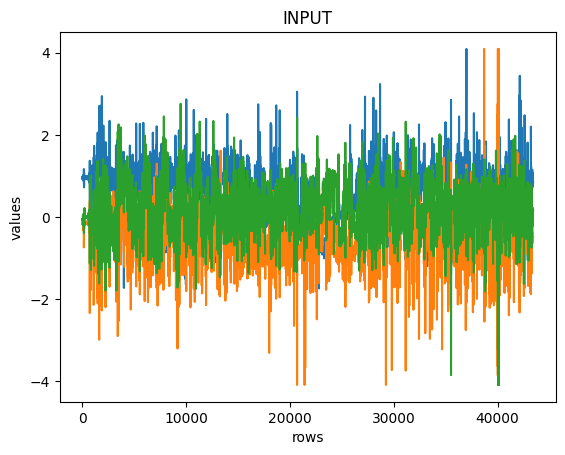

In [4]:
full_src_fn = src_data_folder+'\\'+src_data_fn
data_df = pd.read_csv(full_src_fn)

if isinstance(delete_col,int):
    data_df.drop(data_df.columns[delete_col], axis=1, inplace=True)

if vis_opt:

    plt.plot(data_df)
    plt.title('INPUT')
    plt.xlabel('rows')
    plt.ylabel('values')

print('CSV file loaded')


raw data length = 43423
reduced data length = 1973


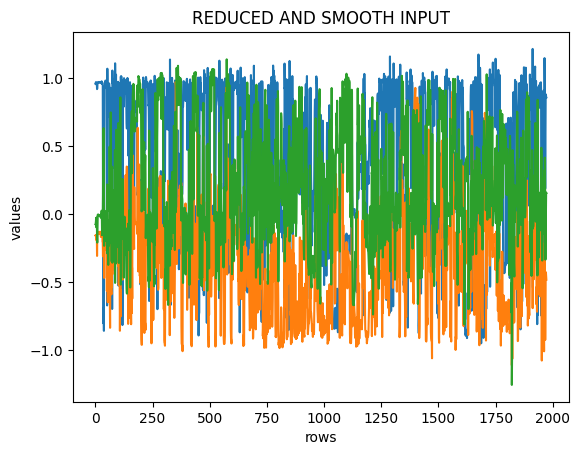

In [5]:
print('raw data length = '+str(data_df.shape[0]))
rf = ceil(data_df.shape[0] / length_limit)
if rf > 1:

    length_rs =  rf * int(len(data_df)/rf)
    data_arr = np.zeros((int(length_rs/rf),data_df.shape[1]))
    for i_col in range(data_df.shape[1]):
        data_arr[:,i_col] = np.mean(data_df.to_numpy()[:length_rs,i_col].reshape(-1, rf), 1)
    print('reduced data length = '+str(data_arr.shape[0]))

    if vis_opt:

        plt.plot(data_arr)
        plt.title('REDUCED AND SMOOTH INPUT')
        plt.xlabel('rows')
        plt.ylabel('values') 
    
else:
    data_arr = data_df.to_numpy()
    print('data was not reduced')
    

***
## Segmentation

In [6]:
def novelty(input_arr,nk_size,sd):

    """
    Computes a novelty score using the offline method (Foote, 2000).
    
    INPUT:
        input_arr: a numpy array
        nk_size: even integer, size of the novelty kernel
        sd: size of the kernel´s Gaussian taper standard deviation
    """
    
    if nk_size%2: # is odd
        print('Error: nk_size should be an even number.')
        exit(1)
    
    output_arr = np.empty( input_arr.shape[0] )
    output_arr.fill(np.nan)
    
    kernel_size_half = int(nk_size/2)
    
    xx = np.linspace(-kernel_size_half,kernel_size_half,nk_size)
    yy = np.linspace(-kernel_size_half,kernel_size_half,nk_size)
    xx, yy = np.meshgrid(xx, yy)
    
    gauss_2D = 1. / (2. * np.pi * sd**2) * np.exp(-(xx**2. / (2. * sd**2.) + yy**2. / (2. * sd**2.)))
    
    kron_cb = np.kron( [[-1,1],[1,-1]] , np.ones( (kernel_size_half,kernel_size_half) ) )
    
    gausscb_kernel = gauss_2D * kron_cb
    
    dist_m = squareform( pdist( np.column_stack( (input_arr, input_arr) ) , 'euclidean') )
    
    for i_start in np.arange(0,input_arr.shape[0]-nk_size):
        i_end = i_start + nk_size
        output_arr[ i_start + kernel_size_half ] = np.sum( gausscb_kernel * dist_m[ i_start:i_end , i_start:i_end ] )

    return output_arr, dist_m


NOVELTY computation time: 0.09997 s.
novelty vector length = 1973


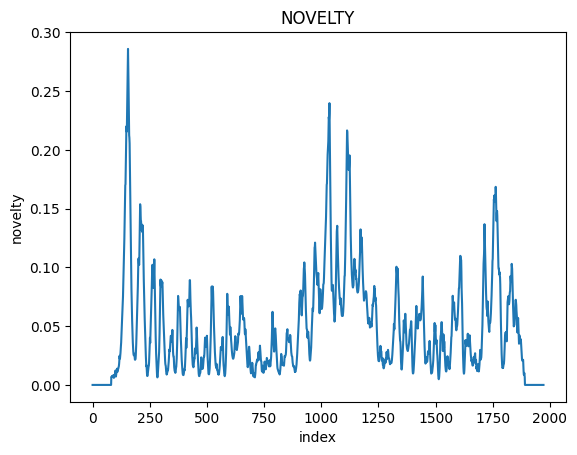

In [7]:
nk_size = int(np.floor(data_arr.shape[0]/ksf))
if nk_size%2: # is odd
    nk_size -= 1

gk_sd = nk_size/4 # kernel's gaussian taper standard deviation

tic = time.time()

novelty_arr, dist_m = novelty(data_arr,nk_size,gk_sd)
novelty_arr[np.isnan(novelty_arr)] = 0

toc =  time.time() - tic

if vis_opt:
    
    plt.plot(novelty_arr)
    plt.title('NOVELTY')
    plt.xlabel('index')
    plt.ylabel('novelty')

print( 'NOVELTY computation time: %0.5f s.' % toc )

print('novelty vector length = '+str(len(novelty_arr)))

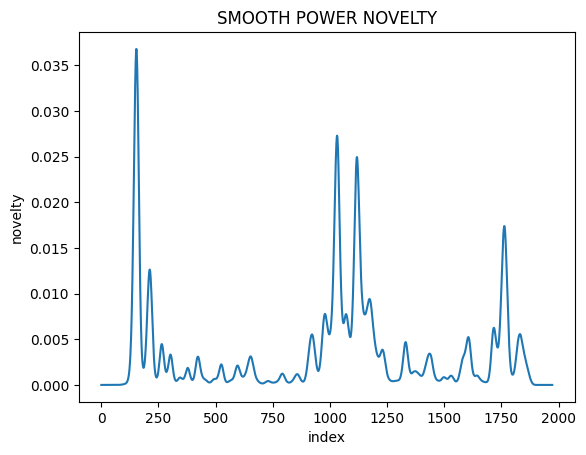

In [8]:
gf_size = int(nk_size/4)
gf_sd = int(gf_size/4)

def gausswin(size,sd):
    x = np.linspace(-int(size/2),int(size/2),size)
    return 1. / np.sqrt( 2. * np.pi * sd**2 ) * np.exp( -x**2 / ( 2. * sd**2 ) )

gaussian_window =  gausswin(gf_size,gf_sd)

smooth_novelty_arr = np.convolve(novelty_arr, gaussian_window, mode="same")
smooth_novelty_arr = smooth_novelty_arr**2

if vis_opt:

    plt.plot(smooth_novelty_arr)
    plt.title('SMOOTH POWER NOVELTY')
    plt.xlabel('index')
    plt.ylabel('novelty')

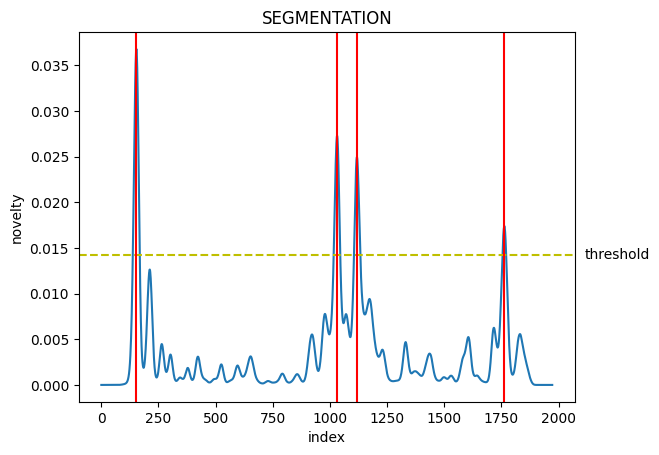

In [9]:

pk_thresh = smooth_novelty_arr.mean() + smooth_novelty_arr.std()*2

pks_idx = find_peaks(smooth_novelty_arr)[0]

pks_val = np.array(list(zip(pks_idx, smooth_novelty_arr[pks_idx])))
sel_pks = [(index, value) for index, value in pks_val if value > pk_thresh] # cols: index and value of peaks over threshold

if vis_opt:

    plt.plot(smooth_novelty_arr)
    plt.title('SEGMENTATION')
    plt.xlabel('index')
    plt.ylabel('novelty')
    plt.axhline(pk_thresh, color='y', linestyle='--')
    axes = plt.gca()
    plt.text( int(axes.get_xlim()[1]*1.02) ,pk_thresh*0.97,'threshold')

    for ln_idx in sel_pks:
        plt.axvline(ln_idx[0], color = 'r', label = 'axvline - full height')
    

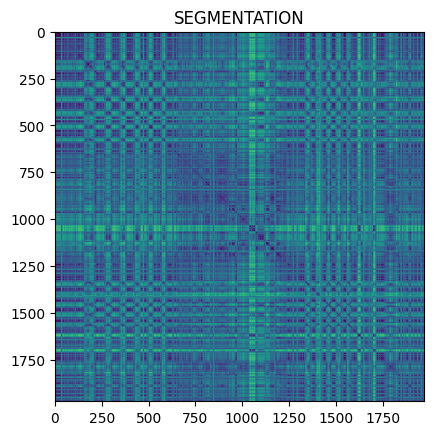

In [10]:
# Just to double-check, a heatmap of the self-similarity matrix:

if vis_opt:
    plt.imshow(dist_m)
    plt.title('SEGMENTATION')